# Paris Airbnb Price
How much should I rent my flat per night?

In this project, we will use several Machine Learning models for predicting the night price of an appartment posted on Airbnb, depending on multiple variables.
The dataset is available at http://insideairbnb.com/get-the-data.html under a Creative Commons CC0 1.0 Universal (CC0 1.0) "Public Domain Dedication" license.

Before starting our work, we should check that the two following components used for Deep Learning are installed when we are running this notebook for the first time on a server, and then reset the Jupyter session.

In [ ]:
!pip3 install keras
!pip install Tensorboard

## 1. Data Preprocessing
In this first part, we will explorate the data from Inside Airbnb.

The goals are to:
- Import the dataset
- Select and clean the more relevant features
- Create variables ready to be exploited by our Machine Learning models 

### 1.1 Import the dataset within the Python kernel
If the data file is not uncompressed yet, we have to uncompress it. The code below should not be run if the data has already been uncompressed. Furthermore, it supposes that the listing.csv.gz file from http://insideairbnb.com/get-the-data.html (Paris, France) is available on the 'data' folder.

In [ ]:
import gzip
import shutil
with gzip.open('data/listings.csv.gz', 'rb') as f_in:
    with open('data/listings.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Now we can import the dataset directly from the .csv file and have a quick look at it.

In [2]:
import pandas as pd
dataset = pd.read_csv('data/listings.csv', low_memory=False)
print(dataset.columns)
print(dataset.shape)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

## 1.2 Select and clean the more relevant features

We can see that there are 96 different variables.

We will keep only the relevant ones, for solving our problem: predicting the price per night of an Airbnb flat in Paris, France. This price per night will be composed of both the price and the cleaning fee, values which we will place in the last columns of the dataset.

*I selected these variables during continuous improvement of the machine learning models for their respective relevance, and the success of the models.*
For example:
- Some of these are directly related (neighbourhood and zipcode directly depends of latitude and longitude / global review score depends on the other review scores)
- Square feet field is rarely fullfilled
- Prices are treated as strings because they contain the '$' character.
- When there is no review, the other review variables are considered 'Nan'.
- Sometimes, the other review variables are 'NaN' even though there are reviews.

In [3]:
import numpy as np
# Keeping only the relevant variables
dataset = dataset[['host_is_superhost', 'property_type','room_type','bed_type','latitude','longitude',
                   'accommodates','bathrooms','bedrooms','number_of_reviews','review_scores_accuracy',
                   'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                   'review_scores_location','review_scores_value','price','cleaning_fee']]
# We drop all the examples which do not contain a price (our dependent variable)
dataset = dataset.dropna(subset=['price'])
# Making the prices and cleaning fees readable(they currently include the '$' sign)
# Adding the prices and cleaning fees to keep a single dependent variable
dataset['price'] = dataset['price'].replace('[\$,]', '', regex=True).astype(float) + dataset['cleaning_fee'].replace('[\$,]', '', regex=True).fillna(0).astype(float)
dataset = dataset.drop(columns=['cleaning_fee'])

# Finally, having a look at the dataset
dataset.iloc[:5,:]

,host_is_superhost,property_type,room_type,bed_type,latitude,longitude,accommodates,bathrooms,bedrooms,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,f,Loft,Entire home/apt,Real Bed,48.869933,2.362511,4,2.0,2.0,0,NaN,NaN,NaN,NaN,NaN,NaN,165.0
1,f,Apartment,Entire home/apt,Real Bed,48.833494,2.318518,2,1.0,1.0,7,10.0,10.0,10.0,10.0,10.0,10.0,125.0
2,f,Apartment,Entire home/apt,Pull-out Sofa,48.851001,2.358690,2,1.0,0.0,148,9.0,9.0,10.0,10.0,10.0,10.0,151.0
3,t,Apartment,Entire home/apt,Real Bed,48.857576,2.352751,4,1.0,2.0,231,10.0,9.0,10.0,10.0,10.0,9.0,165.0
4,f,Apartment,Entire home/apt,Real Bed,48.874642,2.343411,2,1.0,2.0,6,10.0,10.0,10.0,10.0,10.0,10.0,159.0


## 1.3 Creating exploitable variables

We will now divide the dataset between the independent variables and the dependent variable.

In order to do so, we will apply different treatments to the categorical and numerical variables, and will then gather these within X and y variables. We will nevertheless keep the numerical and categorical versions of X, so we can use these in algorithms depending on their qualities.

Once the preprocessing is completed, we will split the dataset between training and test datasets. Since the dataset is not big (less than 60.000 rows) and since we do not consider delivering a production version of the algorithm, we will not create a cross-validation set.

In [4]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Replacing "NaN" values of numerical variables
X_numerical = dataset.values[:,4:-1]
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X_numerical)
X_numerical = imputer.transform(X_numerical)
# Standard scaling the numerical variables
sc_X = StandardScaler()
X_numerical = sc_X.fit_transform(X_numerical)

# Encoding the categorical data
X_categorical = dataset[['host_is_superhost', 'property_type','room_type','bed_type']].astype('str').apply(LabelEncoder().fit_transform).astype('int64')
onehotencoder = OneHotEncoder()
X_categorical = onehotencoder.fit_transform(X_categorical).toarray()

# Merging back numerical and categorical data
X = np.append(X_categorical,X_numerical, axis=1)
y = dataset.values[:,-1:]

# Finally, we can randomly split the examples between training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_numerical, y, test_size = 0.2)
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_categorical, y, test_size = 0.2)

# 2. Machine Learning Models
Now that our data is ready to be properly used, we will create different machine learning models which will try to answer the problem:

*Predict the price per night of an Airbnb flat in Paris.*

In order to evaluate and compare the various models, we will use the **Mean Absolute Error function**:
$$MAE = \frac{\sum_{i=1}^n \lvert x_i - y_i \rvert}{n}$$

## 2.0 Rule of thumb
In order to be able to scale our various models results, we will create a really simple rule of thumb for predicting the price of an Airbnb in Paris: we will use the mean price of the dataset.

In [36]:
from sklearn.metrics import mean_absolute_error
from math import sqrt

# Predicting the price of all airbnbs by using their mean price.
print('The mean price of an Airbnb flat in Paris is {}.'.format(np.mean(y)))
thumb_mae = mean_absolute_error(np.full((y.shape),fill_value = np.mean(y)),y)
print('If we use this mean as a rule of thumb, its mean absolute error is {}.'.format(thumb_rmse))

The mean price of an Airbnb flat in Paris is 136.98919523722049.
If we use this mean as a rule of thumb, its mean absolute error is 77.9029935041523.


## 2.1 Linear Regression

We will start by building a classic linear regression model. We will run it only on the numerical features, since its performance is greatly improved this way.

In [39]:
from sklearn.linear_model import LinearRegression

#The linear regression function which we will use and evaluate
def linear_regression(X_train, y_train, X_test, y_test):
    # Fitting Simple Linear Regression to the Training set
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    train_mae = mean_absolute_error(regressor.predict(X_train),y_train)
    test_mae = mean_absolute_error(regressor.predict(X_test),y_test)
    return train_mae, test_mae

def show_results(training_eval, test_eval):
  plt.gca().set_ylim([0,100])
  plt.plot(training_eval, label='Training MAE')
  plt.plot(test_eval, label='Test MAE')
  plt.legend()
  plt.xlabel('Training set size')
  plt.ylabel('RMSE ($)')
  plt.show()

Let's train and evaluate the model on different amount of data, so we can see its progress.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


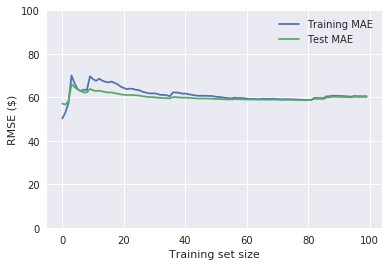

In [40]:
import matplotlib.pyplot as plt

lr_eval = pd.DataFrame(0, index=range(100), columns=['train', 'test']).astype(float)
for i in range(100):
  print('Linear Regression n°{}/100...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_num_train.shape[0]/100)))
  [lr_eval.values[i,0],lr_eval.values[i,1]] = linear_regression(X_num_train[:subset_size,:],y_num_train[:subset_size], X_num_test, y_num_test)
  
show_results(lr_eval['train'], lr_eval['test'])

Both our training and test mean absolute errors are nearly constant around 60.
Although this is better that our rule of thumb (77), they are not decreasing with more data.

As we can see, linear regression does not properly fit the dataset and the problem that we are trying to solve. We should try other machine learning models and see which one we'll choose depending on their respective results.

## 2.2 Polynomial Regression

Let's start by building our polynomial regression function which will fit our training dataset and predict our test dataset, allowing us to measure its performance.

In [41]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(X_train,y_train,X_test,y_test, polynomial_degree):
  polynomialFeatures = PolynomialFeatures(degree = polynomial_degree)
  X_train_poly = polynomialFeatures.fit_transform(X_train)
  polynomialFeatures.fit(X_train_poly, y_train)
  polynomial_regressor = LinearRegression()
  polynomial_regressor.fit(X_train_poly, y_train)
  train_mae = mean_absolute_error(polynomial_regressor.predict(X_train_poly),y_train)
  test_mae = mean_absolute_error(polynomial_regressor.predict(polynomialFeatures.fit_transform(X_test)),y_test)
  return train_mae,test_mae

Now let's measure our polynomial regression root mean squared error for various amount of data.
We'll use a degree of 3 in order to avoid the computation to take too much time.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


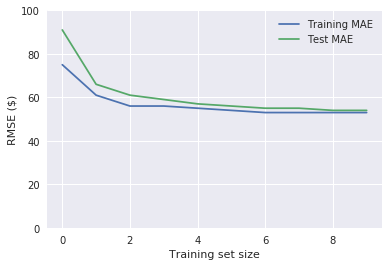

In [54]:
pl_num_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test'])
for i in range(10):
  print('Polynomial Regression n°{}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_num_train.shape[0]/10)))
  [pl_num_eval.values[i,0],pl_num_eval.values[i,1]] = polynomial_regression(X_num_train[:subset_size,:],
                                                                            y_num_train[:subset_size], X_num_test,
                                                                            y_num_test, polynomial_degree = 3)
  
show_results(pl_num_eval['train'], pl_num_eval['test'])

Our mean absolute errors converge slightly over 54, which is better than both our rule of thumb (77) and our linear regression model (60). Nevertheless, our model seem to underfit the training set, and we should either find more interesting features or increase the polynomial degree.

## 2.3 Random Forest Regression

We'll try a Random Forest Regression for this problem and see if we can achieve a good result.

In [46]:
from sklearn.ensemble import RandomForestRegressor

def rf_regression(X_train,y_train,X_test,y_test,estimators):
  rf_regressor = RandomForestRegressor(n_estimators = estimators)
  rf_regressor.fit(X_train, y_train)
  rf_train_mae = mean_absolute_error(rf_regressor.predict(X_train),y_train)
  rf_test_mae = mean_absolute_error(rf_regressor.predict(X_test),y_test)
  return rf_train_mae, rf_test_mae

Let's test our RF regression model with 50 estimators (after a few tests, I realized that this number was the best compromise between computation time and results).

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


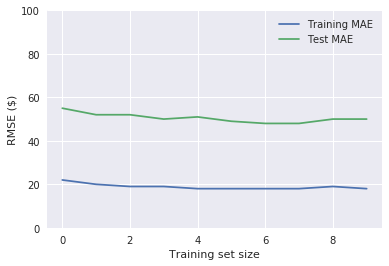

In [62]:
rf_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test'])
for i in range(10):
  print('Random Forest Regression n°{}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [rf_eval.values[i,0],rf_eval.values[i,1]] = rf_regression(X_train[:subset_size,:],y_train[:subset_size].ravel(),
                                                                    X_test, y_test, estimators = 40)

show_results(rf_eval['train'], rf_eval['test'])

Here we are! Our Random Forest Regression is achieving some great results.

We are at around 51 of mean absolute error, which is good by comparison with our linear regression (60), polynomial regression (54).
Furthermore, our training MAE is of 19, which means that our model overfits our training set, and that we can improve it by obtaining more training example.

## 2.4 Deep Neural Network

Finally, we will build a neural network to try to solve our problem.

In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from time import time
from keras.callbacks import TensorBoard
from google.datalab.ml import TensorBoard as tb # if running from a Google Cloud Platform Datalab

regressor = Sequential()
regressor.add(Dense(kernel_initializer = 'normal', activation = 'relu', input_dim = 55, units = 28))
regressor.add(Dense(kernel_initializer = 'normal', activation = 'relu', input_dim = 28, units = 12))
regressor.add(Dense(kernel_initializer = 'normal', activation = 'relu', input_dim = 12, units = 6))
regressor.add(Dense(kernel_initializer = 'normal', input_dim = 6, units = 1))
# Compiling the ANN
regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')

Let's test the deep neural network and look a its performance.

In [50]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
regressor.fit(X_train, y_train, batch_size = 10, epochs = 10, callbacks=[tensorboard])
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
dnn_training_mae = mean_absolute_error(y_train_pred, y_train)
dnn_test_mae = mean_absolute_error(y_pred,y_test)
print('Training MAE: {}\nTest MAE: {}'.format(dnn_training_mae, dnn_test_mae))

Epoch 1/10
47904/47904 [==============================] - 6s 116us/step - loss: 55.8660
Epoch 2/10
47904/47904 [==============================] - 5s 114us/step - loss: 51.6750
Epoch 3/10
47904/47904 [==============================] - 6s 115us/step - loss: 51.4946
Epoch 4/10
47904/47904 [==============================] - 6s 115us/step - loss: 51.4124
Epoch 5/10
47904/47904 [==============================] - 5s 113us/step - loss: 51.3509
Epoch 6/10
47904/47904 [==============================] - 5s 113us/step - loss: 51.2814
Epoch 7/10
47904/47904 [==============================] - 5s 115us/step - loss: 51.2591
Epoch 8/10
47904/47904 [==============================] - 6s 127us/step - loss: 51.2701
Epoch 9/10
47904/47904 [==============================] - 5s 114us/step - loss: 51.2067
Epoch 10/10
47904/47904 [==============================] - 5s 113us/step - loss: 51.2242
Training MAE: 51.03799759409949
Test MAE: 49.01466411241179


In [ ]:
tb.start('./logs') # Only start if it has not been started yet

As we can see, our Deep Neural Network regressor achieves really good results: 49 for our test set, which is even better than the Random Forest regressor (50). Nevertheless, the DNN quickly achieved this level of precision, which means that feeding it more data will not necessarily improve its performance.

# Conclusion

After selecting relevent data and preprocessing it, we used it to train four models:
- Linear Regression
- Polynomial Regression
- Random Forest Regression
- Deep Neural Network Regression

We compared these models between one another and with a simple rule of thumb (predicting the price of an Airbnb flat by using the mean price in Paris).
We obtained the following results:

| Rule of thumb | Linear Regression | Polynomial Regression | Random Forest Regression | Deep Neural Network Regression |
|---------------|-------------------|-----------------------|--------------------------|--------------------------------|
|      77       |        60         |          54           |           51             |              49                |

The Deep Neural Network Regression currently offers the best results, but the Random Forest Regression, with a training error of only 20, might be the machine learning model with the best room for improvement.